#Loading and Understanding the data

In this colab we will get the data we just collected through CoolTerm, load it, and understad it.



In [ ]:
#Get the necessary packages (importing libraries and dependecies)
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
import tensorflow as tf
from scipy import stats

#set the threshhold of prinitng data to console to maximum value
#so avoid the loss of data on console while displaying
np.set_printoptions(threshold=sys.maxsize)
# setting up a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

##Get the data

You will have to manually upload the .txt files in colab (for now) in order to get access to the raw data.

We will define a function **readData()** to get access in the .txt files and also give names to the columns.

🔑**Note:** We start with a smaller datset so we can experiment quickly and experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [ ]:
#--------------To read the data from a file
# defining function for loading the dataset
def readData(filePath):
    # attributes of the dataset
    columnNames = ['x-axis','y-axis','z-axis']
    #read the specified file using pandas function and return the data
    data = pd.read_csv(filePath, header=None, names=columnNames, sep='\t', na_values=';')
    return data

In [ ]:
# Read The Data
capture = "1"
hertz = "60"
volume = "30"
filename = "capture" + capture + "_" + hertz + "hz_" + volume + "vol.txt"
dataset = readData(filename)

# Add a new column for sequential timestamps
dataset['timestamp'] = np.arange(1, len(dataset) + 1)

dataset

,x-axis,y-axis,z-axis,timestamp
0,0.03,-0.07,0.70,1
1,-0.10,0.04,1.20,2
2,0.03,-0.07,0.71,3
3,-0.10,0.04,1.20,4
4,0.03,-0.07,0.71,5
...,...,...,...,...
36309,-0.01,-0.01,0.96,36310
36310,-0.00,0.01,1.14,36311
36311,-0.01,-0.01,0.97,36312
36312,-0.00,0.01,1.14,36313


## Inspect the data (become one with it)

A very crucial step at the beginning of any ML project is becoming one with the data. So we saw that the data was properly place in the *dataset* variable. Now, in order to have a better visualization of the data we will plot it.

In [ ]:
# defining the function to plot a single axis data
# setup color, title, limit and add grid.
def plotAxis(axis, x, y, title):
    axis.plot(x, y, color='green', linewidth=1)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y), max(y)+np.std(y)])
    axis.set_xlim([min(x), max(x)])
    axis.grid(True)

# defining a function to plot the data for a given vibration pattern
def plotVibPattern(data, hz, vol):
    # make subplots of x, y, z over timestamp
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,10), sharex=True)
    plotAxis(ax0, data['timestamp'], data['x-axis'], 'X-AXIS')
    plotAxis(ax1, data['timestamp'], data['y-axis'], 'Y-AXIS')
    plotAxis(ax2, data['timestamp'], data['z-axis'], 'Z-AXIS')
    # set the size and title
    plt.subplots_adjust(hspace=0.2)
    title = "Accelerometer data for " + hz + "HZ and " + vol + " volume"
    fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

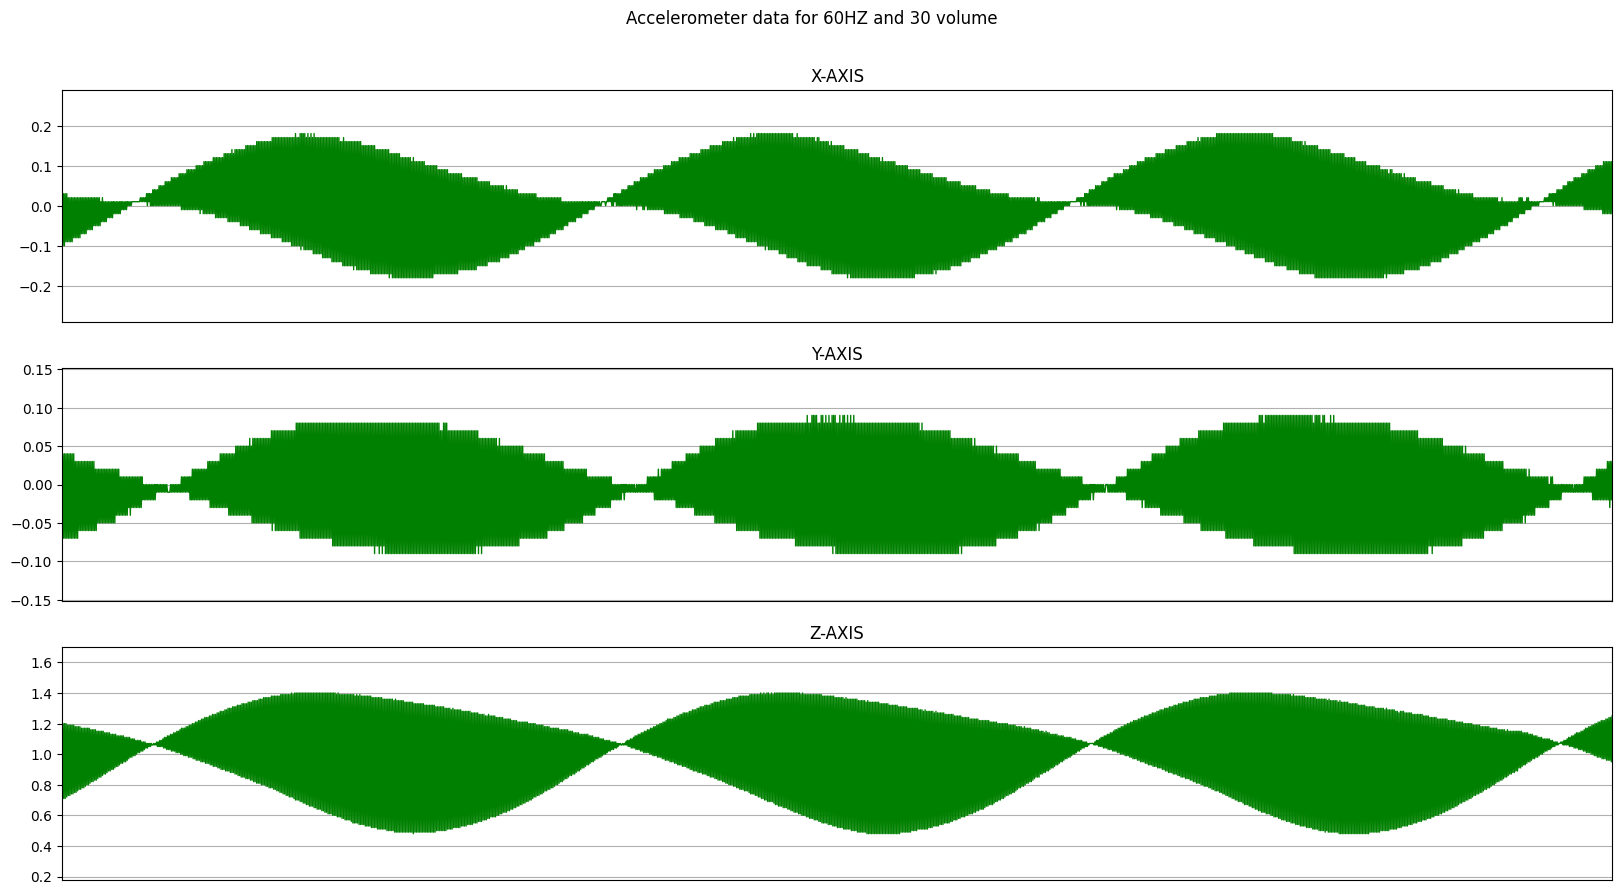

In [ ]:
#select a subset of 2000 samples
subset = dataset[:2000]
plotVibPattern(subset, hertz, volume)


OK! we can definitely see a pattern in all 3 datasets we gathered.

I will now continue testing and also preprocessing the data from the 60hz and 30 volume dataset.

In [ ]:
# Pick a random row from the dataset
random_reading = dataset.sample(n=1)

# our data is actually giant arrays/tensors
#ternsors are inputs to our neural networks
tf.constant(random_reading)

#you can also see the entire dataset as tensors (it'll take a bit longer to compute)
#using this command: tf.constant(dataset)
tf.constant(dataset)

<tf.Tensor: shape=(36314, 4), dtype=float64, numpy=
array([[ 3.0000e-02, -7.0000e-02,  7.0000e-01,  1.0000e+00],
       [-1.0000e-01,  4.0000e-02,  1.2000e+00,  2.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.1000e-01,  3.0000e+00],
       [-1.0000e-01,  4.0000e-02,  1.2000e+00,  4.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.1000e-01,  5.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.2000e+00,  6.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.2000e-01,  7.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  8.0000e+00],
       [ 2.0000e-02, -7.0000e-02,  7.3000e-01,  9.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.0000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.3000e-01,  1.1000e+01],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.2000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.4000e-01,  1.3000e+01],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.4000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.4000e-01,  1.5000e+01],
       [-8.0000e-02,  4.0000e-02,

In [ ]:
#view the image shape
random_reading.shape #returns one row, 4 columns

(1, 4)

##Preprocessing the data

🔑**Note**: As we've discussed before, many ML models, including NNs prefer the values they work with the be between 0 and 1. Knowing this, one of the most common preprocessing steps  is to **normalize** the data. In our case, having just values which are in a certain range we can apply the Min-Max scaling formula.

In [ ]:
# Define the min and max values for x-axis, y-axis, and z-axis
min_values_xyz = np.min(dataset[['x-axis', 'y-axis', 'z-axis']], axis=0)
max_values_xyz = np.max(dataset[['x-axis', 'y-axis', 'z-axis']], axis=0)

# Apply Min-Max scaling to x-axis, y-axis, and z-axis
normalized_xyz = (dataset[['x-axis', 'y-axis', 'z-axis']] - min_values_xyz) / (max_values_xyz - min_values_xyz)

# Combine the normalized values with the 'timestamp' column
normalized_data = pd.concat([normalized_xyz, dataset['timestamp']], axis=1)

print(normalized_data)

         x-axis    y-axis    z-axis  timestamp
0      0.565217  0.269231  0.275510          1
1      0.282609  0.692308  0.785714          2
2      0.565217  0.269231  0.285714          3
3      0.282609  0.692308  0.785714          4
4      0.565217  0.269231  0.285714          5
...         ...       ...       ...        ...
36309  0.478261  0.500000  0.540816      36310
36310  0.500000  0.576923  0.724490      36311
36311  0.478261  0.500000  0.551020      36312
36312  0.500000  0.576923  0.724490      36313
36313  0.478261  0.500000  0.561224      36314

[36314 rows x 4 columns]


To verify that the behaviour did not change after the normalization we can plot again on the newly updated data.

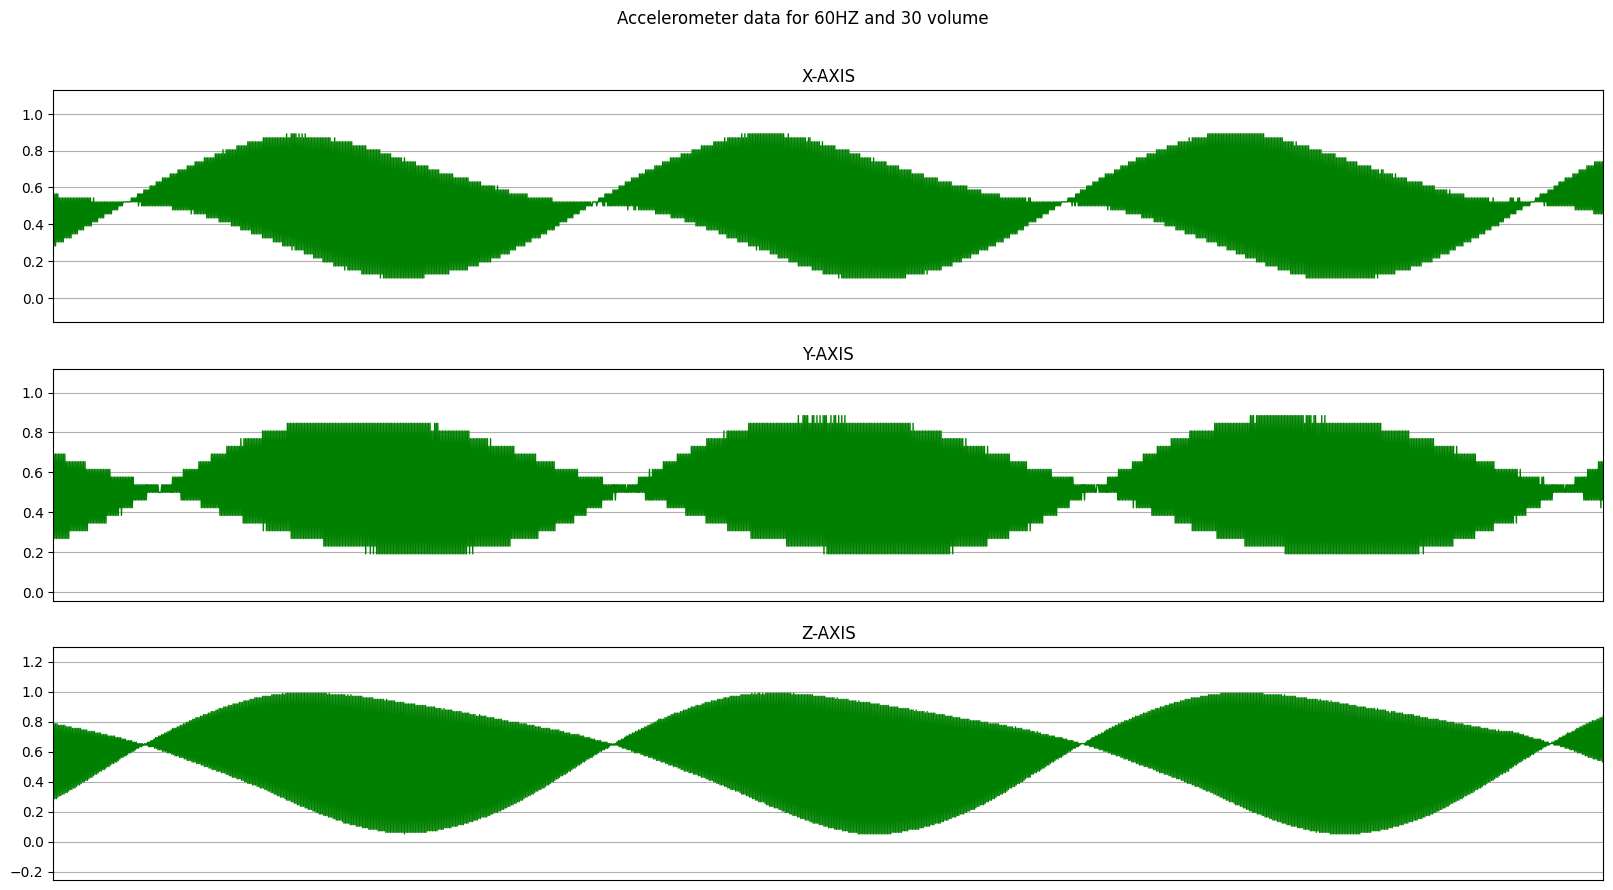

In [ ]:
#select a subset of 2000 samples
subset = normalized_data[:2000]
plotVibPattern(subset, hertz, volume)

As seen in the plot, the behaviour is intact which is exactly what we wanted.

##Splitting the data
Now that we have a reasonable dataset we can work with it is time to start thinking about our neural network. Hence, the first step is to split the data.

I will use the cross-validation method so that we can also test the generazibility of the model.

Partition the data into training and validation, and testing partitions. Train the network using the 70% of the data and 20% for validaiton. Then, set aside 10% for testing.

In this code, train_test_split is used twice to first split the data into training (70%) and a combination of validation and testing (30%). Then, the validation and testing sets are split from the combined set, resulting in a 20% validation set and a 10% testing set.

In [ ]:
from sklearn.model_selection import train_test_split

# Drop the 'timestamp' column
normalized_data = normalized_data.drop(columns=['timestamp'])

# Splitting the data into 70% training, 20% validation, and 10% testing
train_data, temp_data = train_test_split(normalized_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)

# Print the shapes of the resulting sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (25419, 3)
Validation data shape: (7299, 3)
Testing data shape: (3596, 3)


In [ ]:
normalized_data.shape

(25419, 3)

## Picking an Embedding to Build the Model

Note: Changing the size of the embedding (the smallest layer) can produce interesting results. We can also go for layer sizes (we need to experiment).

In [ ]:
from keras.models import Model
from keras import layers, losses

class AnomalyDetector(Model):
  # This is the constructor method for the AnomalyDetector class, where the architecture of the autoencoder is defined.
  def __init__(self):
    #calls the constructor of the parent class (tf.keras.Model) to properly initialize the model.
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu", input_shape = (3, )),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")]) # Smallest Layer Defined Here

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(3, activation="sigmoid")])

  #This method defines the forward pass of the autoencoder model. It takes the input x, which represents the ECG signals.
  #The x is first passed through the encoder, and the resulting compressed representation is obtained.
  #The compressed representation is then passed through the decoder to reconstruct the original ECG signals.
  #The reconstructed signals are returned as the output of the autoencoder.
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

#This line creates an instance of the AnomalyDetector class, creating an autoencoder model.
autoencoder = AnomalyDetector()

In [ ]:
#MAE measures the absolute difference between the original input and the reconstructed output and is commonly used for autoencoders.
autoencoder.compile(optimizer='adam', loss='mae')

## Train the model

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

- normal_train_data: The input data used for training the autoencoder. This consists of normal (non-anomalous) ECG signals.
- normal_train_data: The target data used for training. In this case, the target data is the same as the input data because the autoencoder aims to reconstruct the input data.
- epochs=20: The number of epochs represents how many times the entire training dataset will be used to train the model. One epoch means the model has seen each data point in the training set once.
- batch_size=512: The batch size specifies the number of data points that will be fed to the model in each iteration during training. A larger batch size might lead to faster training, but it requires more memory.
- validation_data=(test_data, test_data): During training, this data is used to evaluate the model's performance after each epoch. The test_data contains normal ECG signals for validation.
- shuffle=True: If True, the training data will be shuffled at the beginning of each epoch. Shuffling the data helps in reducing the bias introduced by the order of the data points during training.

After training, the autoencoder model will be capable of compressing and reconstructing ECG signals. In an anomaly detection setting, the model can be used to detect anomalies by comparing the reconstruction error of test (normal and anomalous) ECG signals with the reconstruction error of normal training data. Anomalies are expected to have higher reconstruction errors compared to normal data.

In [ ]:
history = autoencoder.fit(train_data, train_data,
          epochs=50,
          batch_size=512,
          validation_data=(val_data, val_data),
          shuffle=True)

Epoch 1/50
50/50 [==============================] - 1s 7ms/step - loss: 0.2543 - val_loss: 0.2208
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1619 - val_loss: 0.1078
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0751 - val_loss: 0.0561
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0530 - val_loss: 0.0513
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0494 - val_loss: 0.0480
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.0450
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0432 - val_loss: 0.0418
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0400 - val_loss: 0.0388
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0370 - val_loss: 0.0359
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0333
Epoch 11/50
50/50 [

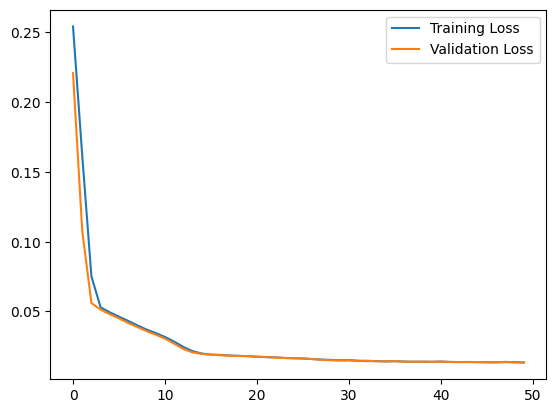

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
print(type(test_data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Convert the DataFrame to a NumPy array
test_data_np = test_data.values

# Get encoded and decoded representations
encoded_data = autoencoder.encoder(test_data_np).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

# Plot a normal vibration pattern from the test set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

plt.figure(figsize=(12, 6))

# Choose a random index from the test set
sample_index = np.random.randint(0, test_data.shape[0])


# Plot original and reconstructed vibration patterns
plt.plot(test_data[sample_index], 'b', label='Original Vibration')
plt.plot(decoded_data[sample_index], 'r', label='Reconstructed Vibration')

# Calculate reconstruction error
reconstruction_error = np.abs(test_data - decoded_data)

# Plot reconstruction error for the chosen sample
plt.fill_between(np.arange(test_data.shape[1]), decoded_data[sample_index], test_data[sample_index], color='lightcoral', alpha=0.5, label='Reconstruction Error')

plt.legend()
plt.show()

KeyError: ignored

<Figure size 1200x600 with 0 Axes>

Before anything this is a note to myself as I will be continuing developing code here and I will add further information after some research to see what time of model would be best for our problem.

- Anomaly detection, which is also known as classification (It's the "What" and "Which" type of questions when working with classification when working with timeseries data). The output is discrete, meaning that it's usually it is an anomaly or it isn't an anomaly.
- Frecasting (questions such as how much and how many). Output is continuous (range of values)

Challenges collecting data in anomaly detection:
- the data is often unbalanced
- anomalous data can be expensive or dangerous to capture

Methods for accurate and efficient anomaly detection: **K-means clustering, auto-encoders as well as neural networks**.